In [7]:
import scipy
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [8]:
from ppg.common import config
from ppg.common.utils import load_data
from ppg.enums import DataColumn, WavelengthIndex

In [15]:
ts1 = load_data(config.DATA_DIR / 'ppg_curve_0.nc')
ts2 = load_data(config.DATA_DIR / 'ppg_curve_1.nc')

In [16]:
# sampling frequency
Fs = 100
Tstep = 1 / Fs

# number of samples
N = len(ts1[DataColumn.TIME])
Fstep = Fs / N

FILTER_ORDER = 5

In [17]:
TS1_DURATION = max(ts1[DataColumn.TIME][:])
TS2_DURATION = max(ts2[DataColumn.TIME][:])

TS1_BEGIN = datetime.fromisoformat(ts1[DataColumn.PPG_CURVE].meas_datetime)
TS2_BEGIN = datetime.fromisoformat(ts2[DataColumn.PPG_CURVE].meas_datetime)
GAP_DURATION = (TS1_BEGIN - TS2_BEGIN - timedelta(seconds=TS2_DURATION)).seconds

In [18]:
# GAP_DURATION = 5

GAP_DURATION

45

In [19]:
from ppg.processing.normalization import ZscoreNormalization
from ppg.processing.filter import BandPassPaddingFilter
from ppg.processing.missing_values import PolynomialInterpolation
from ppg.processing import Pipeline

pipeline = Pipeline([
    PolynomialInterpolation(),
    ZscoreNormalization(),
    BandPassPaddingFilter(order=config.DEFAULT_FILTER_ORDER,
                          sampling_frequency=Fs,
                          cutoff_frequencies=(0.1, 5),
                          padding_size=Fs * config.FILTER_PADDING_MULTIPLIER),

])

In [20]:
ts1_data = pipeline.process(ts1[DataColumn.PPG_CURVE][:])[:, -9000:]
ts2_data = pipeline.process(ts2[DataColumn.PPG_CURVE][:])[:, :9000]

# ts1_data = ts1_data[:]

data_before_gap = ts1_data[WavelengthIndex.RED]
data_after_gap = ts2_data[WavelengthIndex.RED]

gap_data = np.empty((3, GAP_DURATION * Fs))
gap_data[:] = np.nan

In [21]:
ppg_data = np.concatenate((ts1_data, gap_data, ts2_data), axis=1)

time_steps = np.arange(0, ppg_data.shape[1]/Fs, 1/Fs)

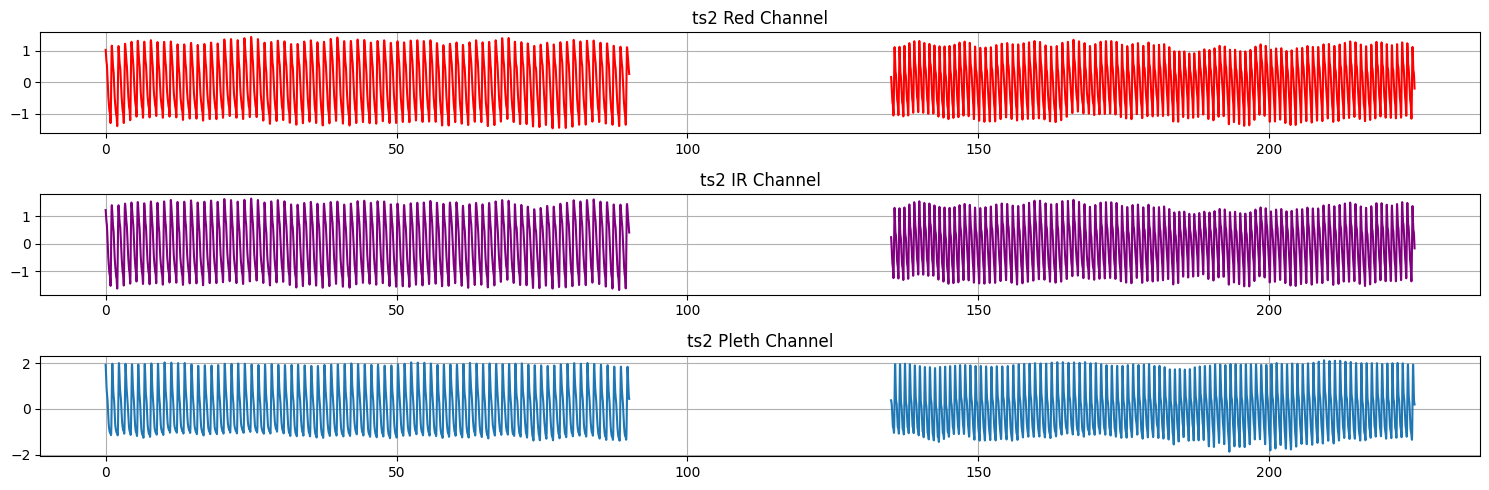

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(3,1,1)
plt.plot(time_steps, ppg_data[WavelengthIndex.RED], color='red')
plt.title('ts2 Red Channel')
plt.grid()

plt.subplot(3,1,2)
plt.plot(time_steps, ppg_data[WavelengthIndex.IR], color='purple')
plt.title('ts2 IR Channel')
plt.grid()

plt.subplot(3,1,3)
plt.plot(time_steps, ppg_data[WavelengthIndex.PLETH])
plt.title('ts2 Pleth Channel')

plt.tight_layout()
plt.grid()
plt.show()

In [23]:
data = ppg_data[WavelengthIndex.RED]

gap_indices = np.argwhere(np.isnan(data))
gap_start = gap_indices.min()
gap_end = gap_indices.max()

In [24]:
df = pd.DataFrame({'value': ppg_data[WavelengthIndex.RED]})

In [25]:
signal = ppg_data[WavelengthIndex.RED]
time = np.arange(0, len(signal)/1000, 0.01)
gap_signal = np.copy(signal)

gap_start = np.where(np.isnan(signal))[0][0]
gap_end = np.where(np.isnan(signal))[0][-1] + 1
gap_length = gap_end - gap_start

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

In [34]:
gap_size = gap_end-gap_start
segments = 2
# OVERLAP_SIZE = (gap_size // segments)
OVERLAP_SIZE = 0
SEGMENT_SIZE = int(((gap_size - OVERLAP_SIZE) / segments) + OVERLAP_SIZE)

_, _, Zxx_before = stft(gap_signal[:gap_start], fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)
_, _, Zxx_after = stft(gap_signal[gap_end:], fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)

Zxx_gap = np.hstack([Zxx_before[:, -1:], Zxx_after[:, :1]])
# Zxx_before = np.hstack([Zxx_before, Zxx_before[:, -1:]])
# Zxx_after = np.hstack([Zxx_after[:, :1], Zxx_after[:, 1:2], Zxx_after[:, 2:]])

In [35]:
SEGMENT_SIZE, OVERLAP_SIZE

(2250, 0)

In [36]:
Zxx_before.shape, Zxx_after.shape, Zxx_before[:, -1:].shape

((1126, 4), (1126, 4), (1126, 1))

In [37]:
STRIP_SIZE = 5

t, x_gap_left = istft(Zxx_before[:, -1:], fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)
t, x_gap_right = istft(Zxx_after[:, :1], fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)


x_gap_left = x_gap_left[STRIP_SIZE:-STRIP_SIZE]
x_gap_right = x_gap_right[STRIP_SIZE:-STRIP_SIZE]

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\scipy\signal\_spectral_py.py:1492: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")


In [38]:
x_gap_left.shape, x_gap_right.shape

((2240,), (2240,))

In [39]:
# t, x_before_expanded = istft(Zxx_before, fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)
# t, x_after_expanded = istft(Zxx_after, fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

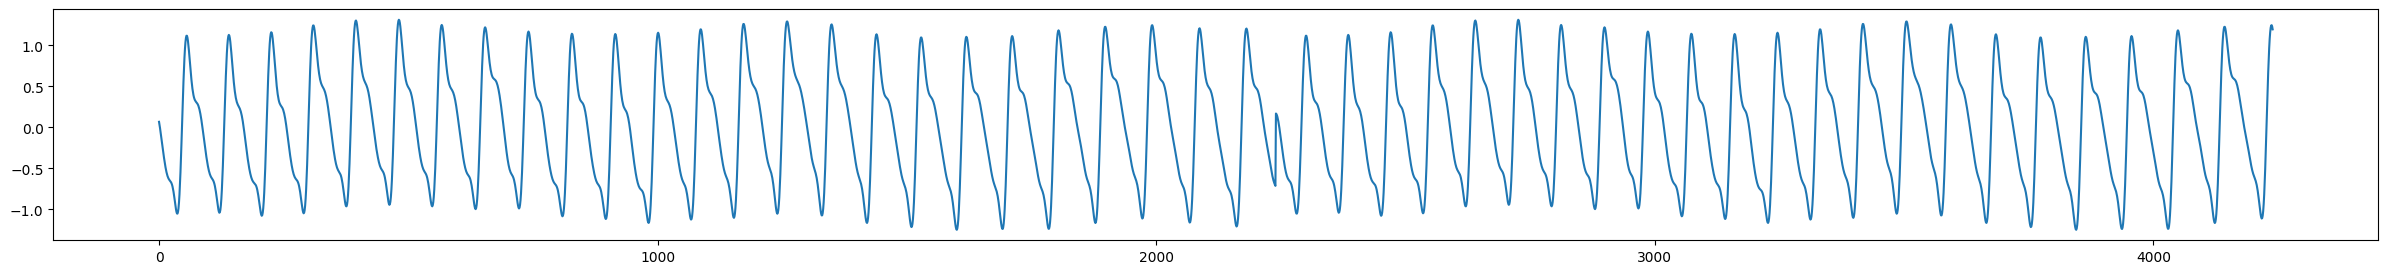

In [40]:
plt.figure(figsize=(30,3))
plt.plot(np.concatenate([x_gap_right, gap_signal[gap_end:][:2000]]))
# plt.plot(gap_signal[gap_end:])

In [41]:
def _concatenate_time_series(s1: np.ndarray,
                             s2: np.ndarray,
                             precision: float = 0.01,
                             max_correlation_phase_shift: int = 200) -> np.ndarray:
    """
    Concatenate two time series by considering phase shift and derivation sign.
    Additional fine alignment is applied to smooth transitions between signals.
    """
    threshold = np.abs((max(s1) - min(s1)) * precision)
    alignment_value = s2[0]
    alignment_gradient_sign = np.sign(np.diff(s2[:2]))

    # shift = _get_phase_shift(s1, s2)
    # if np.abs(shift) < max_correlation_phase_shift:
    #     if shift < 0:
    #         s1 = s1[:shift]
    #     else:
    #         s2 = s2[shift:]

    fine_shift_index = 0
    for i, v in enumerate(reversed(s1)):
        difference = np.abs(alignment_value - v)
        actual_gradient_sign = np.sign(np.diff(s1[-i-2:-i]))
        if difference <= threshold and alignment_gradient_sign == actual_gradient_sign:
            fine_shift_index = i
            break

    return np.concatenate([s1[:len(s1)-fine_shift_index], s2])

In [42]:
segments = 10
OVERLAP_SIZE = (gap_size // segments)
SEGMENT_SIZE = int(((gap_size - OVERLAP_SIZE) / segments) + OVERLAP_SIZE)

x = _concatenate_time_series(gap_signal[:gap_start], x_gap_left, precision=0.01)
x = _concatenate_time_series(x , x_gap_right, precision=0.01)
x = _concatenate_time_series(x, gap_signal[gap_end:], precision=0.01)

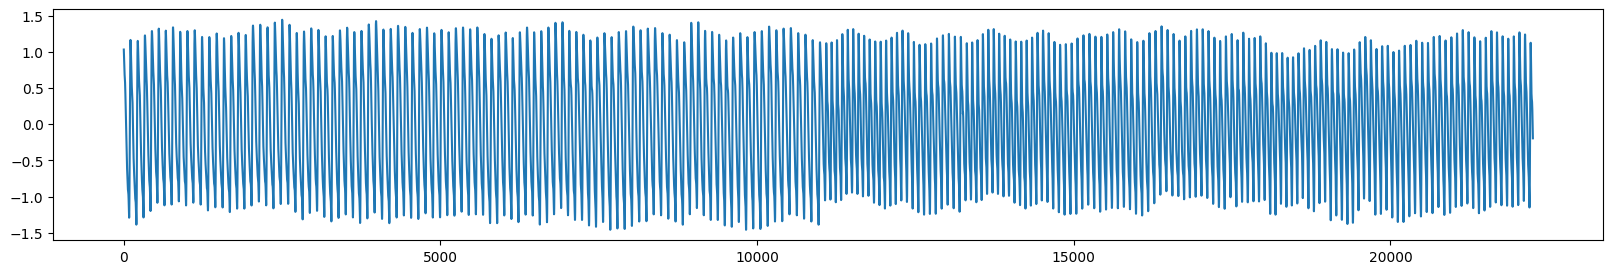

In [43]:
plt.figure(figsize=(20,3))
plt.plot(x)

In [44]:
frequencies, times, Zxx = stft(x, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\scipy\signal\_spectral_py.py:1492: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")


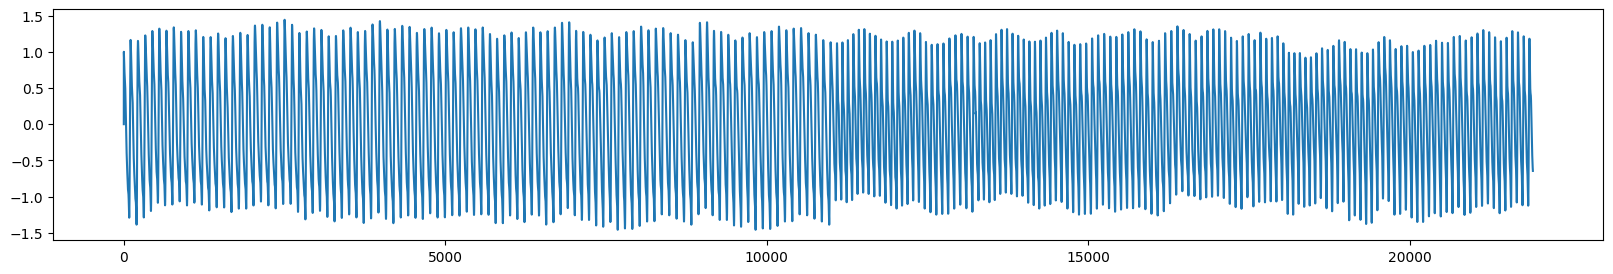

In [45]:
t, x_rec = istft(Zxx, fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

plt.figure(figsize=(20,3))
plt.plot(x_rec)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


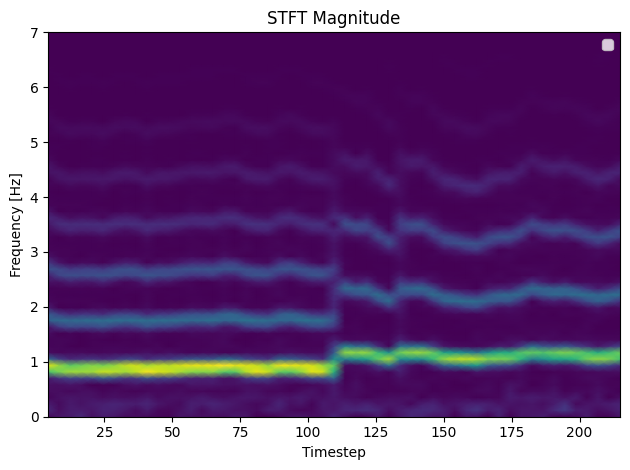

In [46]:
fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
ax.set_ylim([0, 7])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [47]:
data = Zxx

stft_gap_start = data.shape[1]//2 - 1
stft_gap_end = stft_gap_start + 2

original_nan_indices = np.isnan(data)
original_nan_indices[:, stft_gap_start:stft_gap_end] = True


stft_gap_start, stft_gap_end

(25, 27)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


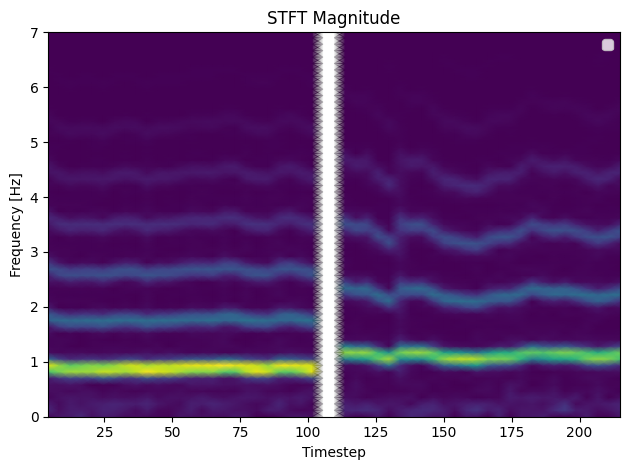

In [48]:
fig, ax = plt.subplots()
data = np.abs(Zxx)
data[original_nan_indices] = np.NaN

plt.pcolormesh(times, frequencies, data, shading='gouraud')
ax.set_ylim([0, 7])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [1143]:
data.shape

(226, 49)

In [1803]:
import numpy as np
from scipy.signal import istft
from scipy.ndimage import generic_filter
from scipy.interpolate import griddata


data = np.abs(Zxx)
stft_gap_start = data.shape[1]//2 - 1
stft_gap_end = stft_gap_start + 2

original_nan_indices = np.isnan(data)
original_nan_indices[:, stft_gap_start:stft_gap_end] = True

data[original_nan_indices] = np.NaN


def nanmedian(values):
    return np.nanmedian(values)


filter_size = 2
n_iterations = 20

steps = 0

extended_nan_indices = np.zeros_like(data, dtype=bool)
for i in range(data.shape[1]):
    if np.any(original_nan_indices[:, i]):
        start = max(0, i - steps)
        end = min(data.shape[1], i + steps + 1)
        extended_nan_indices[:, start:end] = True

for _ in range(n_iterations):
    data_median = generic_filter(data, nanmedian, size=filter_size)

    data[extended_nan_indices] = data_median[extended_nan_indices]
    updated_nan_indices = np.isnan(data)
    known_indices = np.argwhere(~updated_nan_indices)
    nan_indices = np.argwhere(updated_nan_indices)
    data[updated_nan_indices] = griddata(known_indices,
                                         data[~updated_nan_indices].flatten(),
                                         nan_indices,
                                         method='cubic')
    remaining_nan_indices = np.isnan(data)
    if np.any(remaining_nan_indices):
        data[remaining_nan_indices] = griddata(known_indices,
                                               data[~updated_nan_indices].flatten(),
                                               remaining_nan_indices[np.isnan(data)],
                                               method='nearest')

In [1804]:
phase = np.angle(Zxx)
complex_data = data * np.exp(1j * phase)

_, reconstructed_signal = istft(complex_data, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


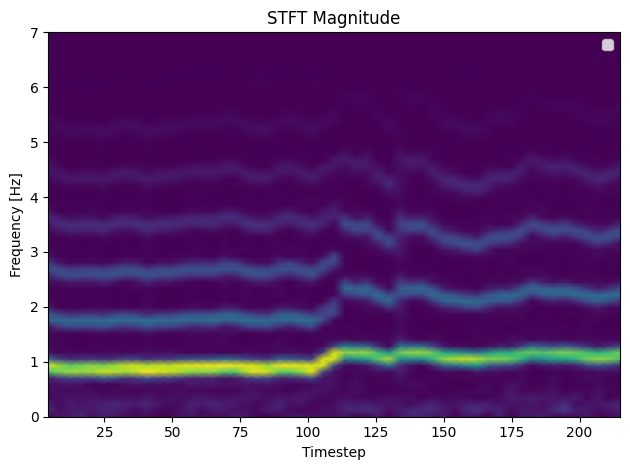

In [1805]:
fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies,  np.abs(complex_data), shading='gouraud')
ax.set_ylim([0, 7])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

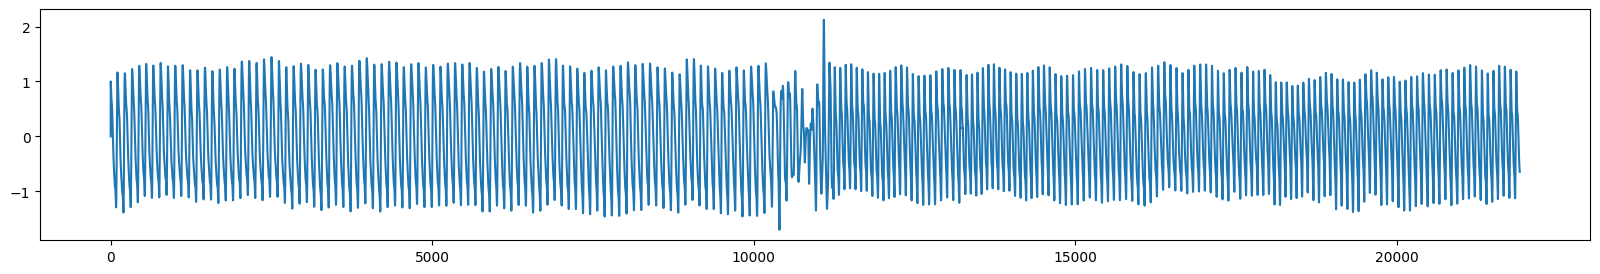

In [1806]:
plt.figure(figsize=(20,3))
plt.plot(reconstructed_signal)

In [1815]:
def griffin_lim_with_known_phase(magnitude_spectrogram, known_phase, known_phase_mask, n_iter=100, n_fft=2048, hop_length=512):

    spectrogram_shape = magnitude_spectrogram.shape

    phase = np.random.uniform(-np.pi, np.pi, spectrogram_shape)
    phase = known_phase * known_phase_mask + phase * (1 - known_phase_mask)

    # phase = known_phase
    complex_spectrogram = magnitude_spectrogram * np.exp(1j * phase)

    y = np.zeros((spectrogram_shape[1] - 1) * hop_length + n_fft)

    for i in range(n_iter):
        _, y = istft(complex_spectrogram, nperseg=n_fft, noverlap=n_fft - hop_length)

        if i < n_iter - 1:
            _, _, complex_spectrogram_next = stft(y, nperseg=n_fft, noverlap=n_fft - hop_length)
            phase_next = np.angle(complex_spectrogram_next)
            phase = known_phase * known_phase_mask + phase_next * (1 - known_phase_mask)
            complex_spectrogram = magnitude_spectrogram * np.exp(1j * phase)

    return y

x_rec = griffin_lim_with_known_phase(data, np.angle(Zxx), np.invert(original_nan_indices, dtype=bool), n_iter=5000, n_fft=SEGMENT_SIZE, hop_length=SEGMENT_SIZE-OVERLAP_SIZE)

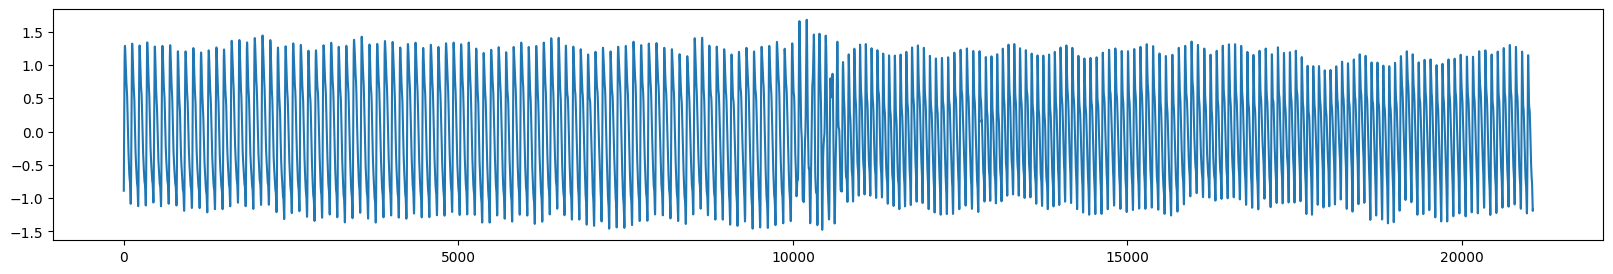

In [1816]:
plt.figure(figsize=(20,3))
plt.plot(x_rec)

In [1576]:
# segments = 2
# OVERLAP_SIZE = 300
# SEGMENT_SIZE = int(((gap_size - OVERLAP_SIZE) / segments) + OVERLAP_SIZE)

SEGMENT_SIZE = 1000
OVERLAP_SIZE = 500
frequencies, times, Zxx = stft(gap_signal, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)

Zxx.shape, SEGMENT_SIZE, OVERLAP_SIZE, frequencies.shape

((501, 36), 1000, 500, (501,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


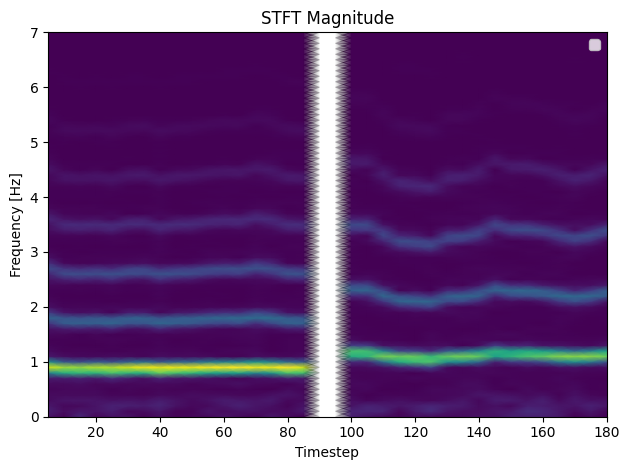

In [1578]:
fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
ax.set_ylim([0, 7])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

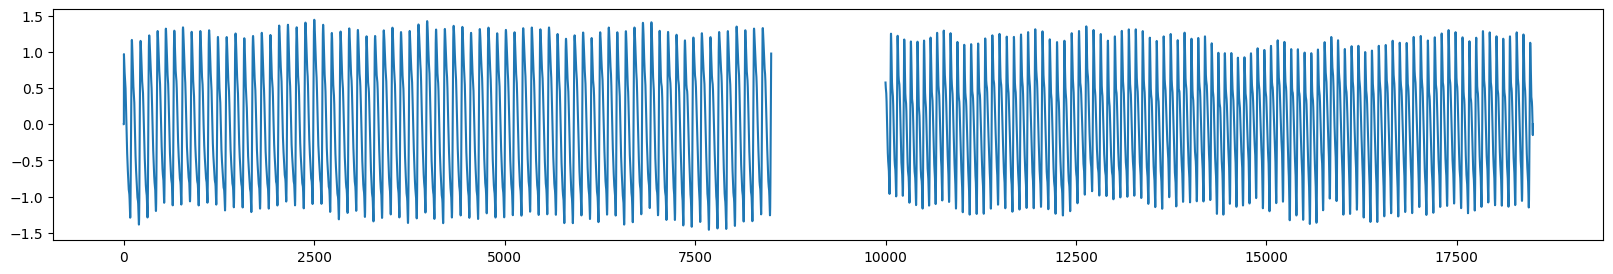

In [1579]:
_, reconstructed_signal = istft(Zxx, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)
plt.figure(figsize=(20,3))
plt.plot(reconstructed_signal)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


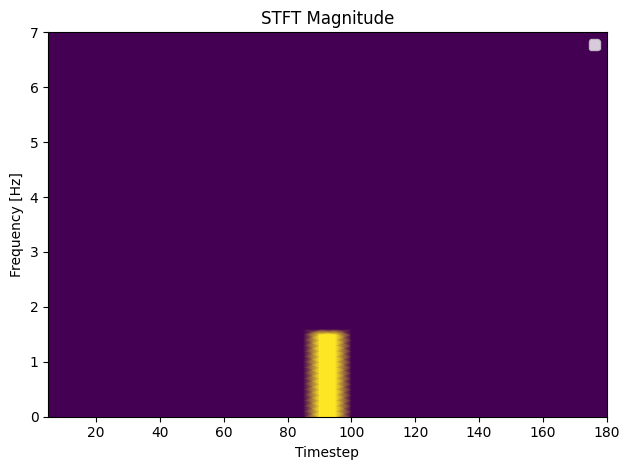

In [1610]:
data = np.abs(Zxx)
original_nan_indices = np.isnan(data)
original_nan_indices[np.where(frequencies > 1.5)[0], :] = False
fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, original_nan_indices, shading='gouraud')
ax.set_ylim([0, 7])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [1615]:
from scipy.ndimage import gaussian_filter

# data = gaussian_filter(data, sigma=1)

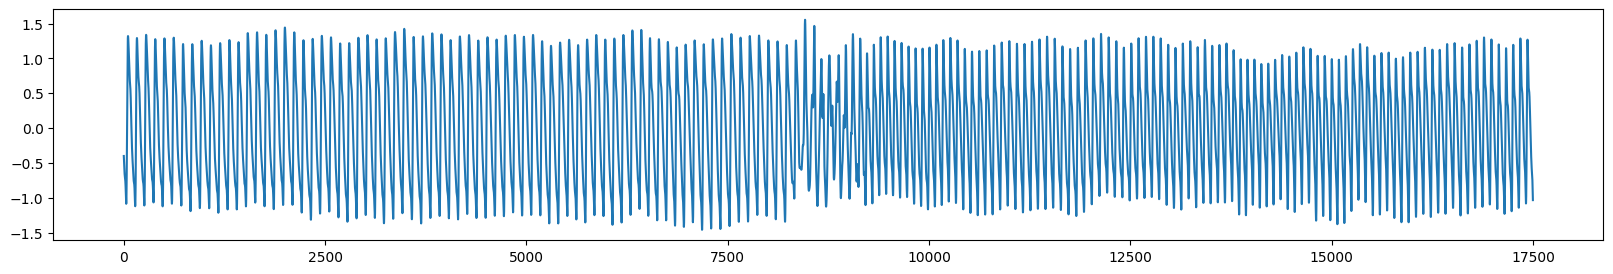

In [1617]:
plt.figure(figsize=(20,3))
plt.plot(x_rec)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


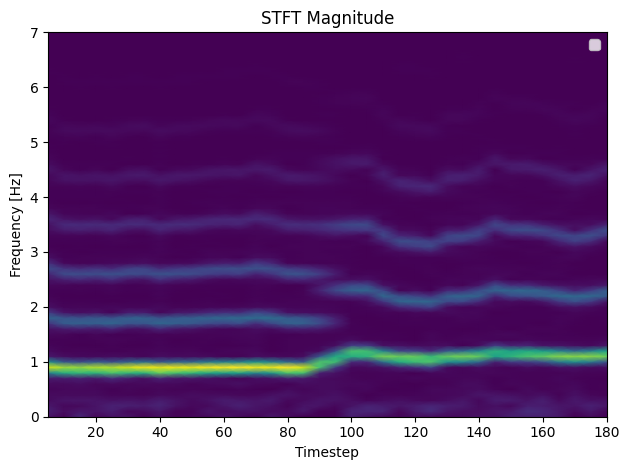

In [1602]:
fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(complex_data), shading='gouraud')
ax.set_ylim([0, 7])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

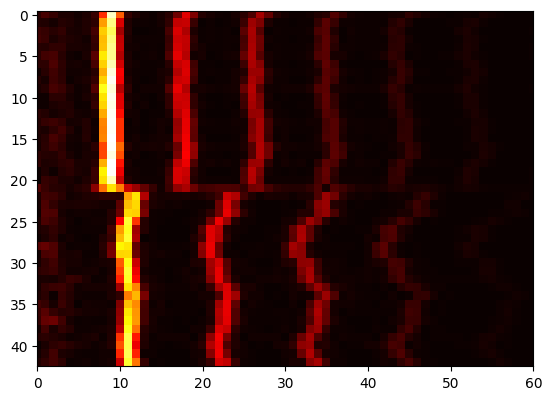

In [2138]:
fig, ax = plt.subplots()
plt.imshow(filtered.T, cmap='hot', interpolation='nearest')
ax.set_xlim([0, 60])
plt.show()

In [1846]:
from hmmlearn import hmm
import numpy as np

# Assume "data" is your time series data with NaNs
# data = ...

# Split data into before and after gap
# data_before_gap = data[:15000]
# data_after_gap = data[15030:]

# Remove NaN values from the data before and after the gap
data_before_gap = data_before_gap[~np.isnan(data_before_gap)]
data_after_gap = data_after_gap[~np.isnan(data_after_gap)]

# Prepare the sequences for the model
sequences_before_gap = data_before_gap.reshape(-1,1)
sequences_after_gap = data_after_gap.reshape(-1,1)

# Assume some basic parameters for HMM (you might need to adjust these to your case)
n_components = 50

# Train a HMM on the data before and after the gap
model_before_gap = hmm.GaussianHMM(n_components=n_components)
model_before_gap.fit(sequences_before_gap)

model_after_gap = hmm.GaussianHMM(n_components=n_components)
model_after_gap.fit(sequences_after_gap)

# Generate the missing values using models
predicted_values_before_gap, _ = model_before_gap.sample(1500)
predicted_values_after_gap, _ = model_after_gap.sample(1500)

# Fill the gap in the original data
d = np.concatenate((predicted_values_before_gap.flatten(), predicted_values_after_gap.flatten()))


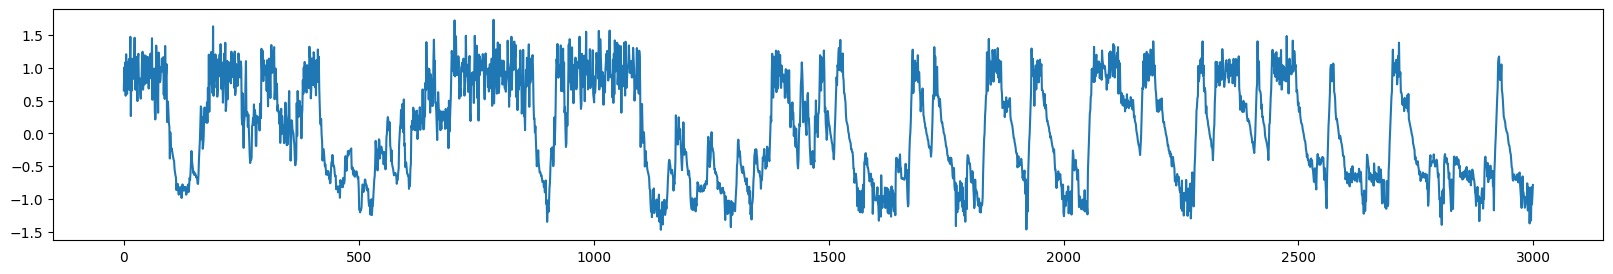

In [1847]:
plt.figure(figsize=(20,3))
plt.plot(d)

In [1866]:
from sklearn.ensemble import RandomForestRegressor

def create_lags(data, n_lags):
    lagged_data = pd.DataFrame(data)
    for i in range(1, n_lags+1):
        lagged_data['Lag_' + str(i)] = lagged_data[data.columns[0]].shift(i)
    return lagged_data

n_lags = 10
lagged_data = create_lags(data, n_lags)

train_data = lagged_data.dropna()
predict_data = lagged_data[gap_start:gap_end]

rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(train_data.drop(data.columns[0], axis=1), train_data[data.columns[0]])

d = rf.predict(predict_data.drop(data.columns[0], axis=1))


In [1867]:
predict_data

0     Lag_1     Lag_2     Lag_3     Lag_4     Lag_5     Lag_6  \
3000  0.258698  0.303053  0.346322  0.388068  0.427842  0.465206  0.499764   
3001  0.213665  0.258698  0.303053  0.346322  0.388068  0.427842  0.465206   
3002  0.168323  0.213665  0.258698  0.303053  0.346322  0.388068  0.427842   
3003  0.122994  0.168323  0.213665  0.258698  0.303053  0.346322  0.388068   
3004  0.077956  0.122994  0.168323  0.213665  0.258698  0.303053  0.346322   
...        ...       ...       ...       ...       ...       ...       ...   
7495  0.759472  0.787812  0.817717  0.848410  0.879144  0.909293  0.938425   
7496  0.733412  0.759472  0.787812  0.817717  0.848410  0.879144  0.909293   
7497  0.710195  0.733412  0.759472  0.787812  0.817717  0.848410  0.879144   
7498  0.690166  0.710195  0.733412  0.759472  0.787812  0.817717  0.848410   
7499  0.673414  0.690166  0.710195  0.733412  0.759472  0.787812  0.817717   

         Lag_7     Lag_8     Lag_9    Lag_10  
3000  0.531189  0.559256  0.583874  0.605110  
3001  0.499764  0.531189  0.559256  0.583874  
3002  0.465206  0.499764  0.531189  0.559256  
3003  0.427842  0.465206  0.499764  0.531189  
3004  0.388068  0.427842  0.465206  0.499764  
...        ...       ...       ...       ...  
7495  0.966341  0.993084  1.018892  1.044118  
7496  0.938425  0.966341  0.993084  1.018892  
7497  0.909293  0.938425  0.966341  0.993084  
7498  0.879144  0.909293  0.938425  0.966341  
7499  0.848410  0.879144  0.909293  0.938425  

[4500 rows x 11 columns]

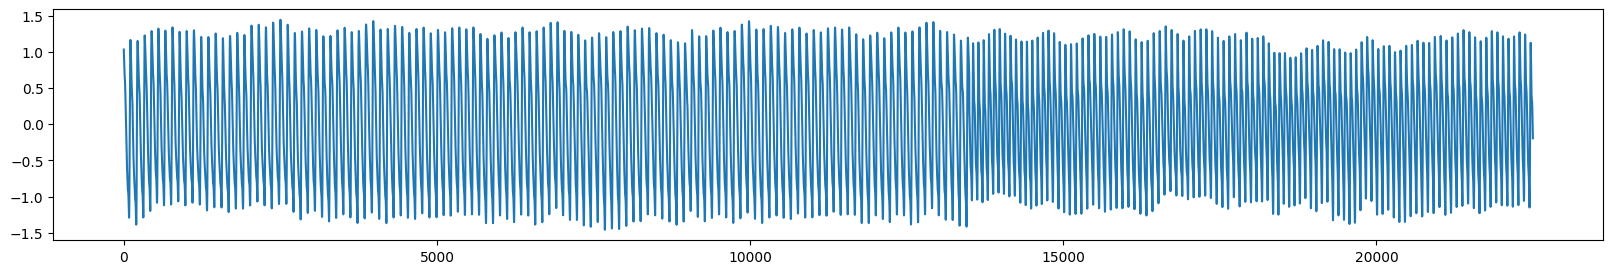

In [1868]:
plt.figure(figsize=(20,3))
# plt.plot(d)
d= np.concatenate([data_before_gap, d, data_after_gap])
plt.plot(d)

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\scipy\signal\_spectral_py.py:1492: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


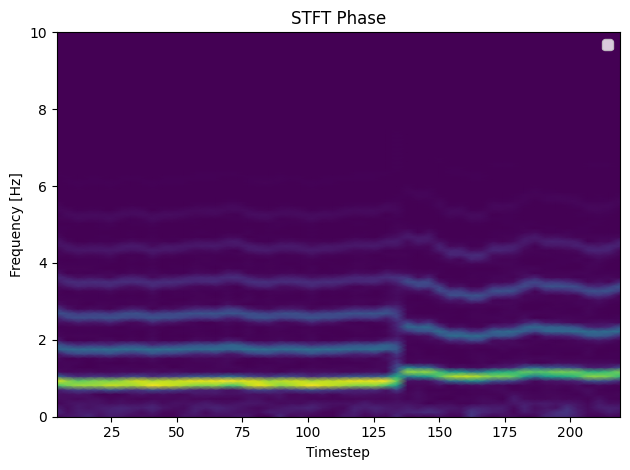

In [1869]:
frequencies, times, complex_data = stft(d, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)
_, reconstructed_signal = istft(complex_data, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(complex_data), shading='gouraud')
ax.set_ylim([0, 10])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Phase')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [25]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

def create_lags(data, n_lags):
    df = pd.DataFrame(data)
    columns = [df]
    for i in range(1, n_lags+1):
        columns.append(df.shift(i))
    lagged_data = pd.concat(columns, axis=1)
    lagged_data.columns = ['lag_'+str(i) for i in range(n_lags+1)]
    lagged_data = lagged_data.dropna()
    return lagged_data


# The number of lags
n_lags = 15
df = pd.DataFrame({'value': gap_signal})

data_before_gap = gap_signal[:gap_start]
data_after_gap = gap_signal[gap_end+1:]
data_gap = gap_signal[gap_start:gap_end+1]

# Create lagged data
pre_gap_data = create_lags(data_before_gap[-4000:], n_lags)
post_gap_data = create_lags(data_after_gap[:4000], n_lags)


pre_gap_data = pd.concat([pre_gap_data, post_gap_data.head(100)])
post_gap_data = pd.concat([pre_gap_data.tail(100), post_gap_data])

# pre_gap_data = pre_gap_data.sample(frac=1)
# post_gap_data = post_gap_data.sample(frac=1)

rf_pre_gap = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6, max_depth=12)
rf_post_gap = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6, max_depth=12)

In [26]:
pre_gap_data

lag_0     lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
15   1.293623  1.271525  1.233300  1.176257  1.098175  0.997580  0.873994   
16   1.302474  1.293623  1.271525  1.233300  1.176257  1.098175  0.997580   
17   1.300903  1.302474  1.293623  1.271525  1.233300  1.176257  1.098175   
18   1.291476  1.300903  1.302474  1.293623  1.271525  1.233300  1.176257   
19   1.276358  1.291476  1.300903  1.302474  1.293623  1.271525  1.233300   
..        ...       ...       ...       ...       ...       ...       ...   
110 -0.621684 -0.612305 -0.601432 -0.588182 -0.571905 -0.552187 -0.528825   
111 -0.630664 -0.621684 -0.612305 -0.601432 -0.588182 -0.571905 -0.552187   
112 -0.640505 -0.630664 -0.621684 -0.612305 -0.601432 -0.588182 -0.571905   
113 -0.652550 -0.640505 -0.630664 -0.621684 -0.612305 -0.601432 -0.588182   
114 -0.668117 -0.652550 -0.640505 -0.630664 -0.621684 -0.612305 -0.601432   

        lag_7     lag_8     lag_9    lag_10    lag_11    lag_12    lag_13  \
15   0.728125  0.561973  0.378830  0.183170 -0.019583 -0.223372 -0.421902   
16   0.873994  0.728125  0.561973  0.378830  0.183170 -0.019583 -0.223372   
17   0.997580  0.873994  0.728125  0.561973  0.378830  0.183170 -0.019583   
18   1.098175  0.997580  0.873994  0.728125  0.561973  0.378830  0.183170   
19   1.176257  1.098175  0.997580  0.873994  0.728125  0.561973  0.378830   
..        ...       ...       ...       ...       ...       ...       ...   
110 -0.501799 -0.471230 -0.437345 -0.400440 -0.360855 -0.318956 -0.275132   
111 -0.528825 -0.501799 -0.471230 -0.437345 -0.400440 -0.360855 -0.318956   
112 -0.552187 -0.528825 -0.501799 -0.471230 -0.437345 -0.400440 -0.360855   
113 -0.571905 -0.552187 -0.528825 -0.501799 -0.471230 -0.437345 -0.400440   
114 -0.588182 -0.571905 -0.552187 -0.528825 -0.501799 -0.471230 -0.437345   

       lag_14    lag_15  
15  -0.609061 -0.779340  
16  -0.421902 -0.609061  
17  -0.223372 -0.421902  
18  -0.019583 -0.223372  
19   0.183170 -0.019583  
..        ...       ...  
110 -0.229788 -0.183357  
111 -0.275132 -0.229788  
112 -0.318956 -0.275132  
113 -0.360855 -0.318956  
114 -0.400440 -0.360855  

[4085 rows x 16 columns]

In [ ]:
rf_pre_gap.fit(pre_gap_data.drop('lag_0', axis=1), pre_gap_data['lag_0'])
rf_post_gap.fit(post_gap_data.drop('lag_0', axis=1), post_gap_data['lag_0'])

In [2268]:
pre_gap_data

lag_0  rolling_std     lag_1     lag_2     lag_3     lag_4     lag_5  \
8360 -1.012192     0.844572 -0.974576 -0.942786 -0.917201 -0.897546 -0.883028   
4223  1.139610     0.851318  1.169072  1.197838  1.225649  1.251953  1.275798   
1671 -1.148387     0.750453 -1.112388 -1.075072 -1.039123 -1.006531 -0.978564   
7091 -0.520158     0.832565 -0.489376 -0.458466 -0.427162 -0.395186 -0.362268   
7267  0.963285     0.830446  0.994573  1.025255  1.055641  1.085969  1.116245   
...        ...          ...       ...       ...       ...       ...       ...   
7910 -1.424211     0.832461 -1.446461 -1.445918 -1.426955 -1.394303 -1.352685   
2550 -0.164323     0.788505 -0.128302 -0.090117 -0.049820 -0.007514  0.036644   
1558 -1.116598     0.754932 -1.085681 -1.050150 -1.013217 -0.977513 -0.944994   
7084 -0.292641     0.833122 -0.255556 -0.216791 -0.176301 -0.134107 -0.090304   
5716  0.600045     0.832087  0.617781  0.638243  0.661879  0.688890  0.719231   

         lag_6     lag_7     lag_8     lag_9    lag_10    lag_11    lag_12  \
8360 -0.872500 -0.864624 -0.858015 -0.851370 -0.843564 -0.833715 -0.821213   
4223  1.295744  1.309829  1.315591  1.310156  1.290398  1.253166  1.195552   
1671 -0.955807 -0.938240 -0.925358 -0.916307 -0.910021 -0.905355 -0.901204   
7091 -0.328156 -0.292641 -0.255556 -0.216791 -0.176301 -0.134107 -0.090304   
7267  1.146089  1.174597  1.200252  1.220892  1.233747  1.235567  1.222825   
...        ...       ...       ...       ...       ...       ...       ...   
7910 -1.306492 -1.259527 -1.214828 -1.174570 -1.140058 -1.111780 -1.089521   
2550  0.082443  0.129608  0.177805  0.226643  0.275673  0.324406  0.372318   
1558 -0.916915 -0.893864 -0.875840 -0.862367 -0.852623 -0.845583 -0.840142   
7084 -0.045062  0.001368  0.048657  0.096398  0.144109  0.191249  0.237227   
5716  0.752623  0.788604  0.826582  0.865908  0.905937  0.946088  0.985870   

        lag_13    lag_14    lag_15  
8360 -0.805727 -0.787181 -0.765715  
4223  1.115193  1.010562  0.881236  
1671 -0.896587 -0.890718 -0.883033  
7091 -0.045062  0.001368  0.048657  
7267  1.191982  1.139816  1.063749  
...        ...       ...       ...  
7910 -1.072512 -1.059601 -1.049428  
2550  0.418872  0.463538  0.505820  
1558 -0.835232 -0.829908 -0.823413  
7084  0.281424  0.323222  0.362034  
5716  1.024886  1.062802  1.099280  

[8001 rows x 17 columns]

In [2257]:

rolling_std = pd.Series(data_before_gap[-rolling_size:]).rolling(window=rolling_size).std().dropna().values[-1]
vector = np.concatenate([[rolling_std], np.flip(data_before_gap[-n_lags:])])
x_win = pd.DataFrame(vector).T
x_win.columns = ['rolling_std'] + ['lag_'+str(i+1) for i in range(n_lags)]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

weights = sigmoid(np.linspace(-4, 4, gap_size))

predictions = []
for i in range(gap_size):
    prediction_before = rf_pre_gap.predict(x_win)[0]
    prediction_after = rf_post_gap.predict(x_win)[0]

    weight = 1 - i/gap_size
    # weight = 1 - weights[i]
    prediction = weight*prediction_before + (1-weight)*prediction_after
    # prediction = prediction_after

    rolling_std = pd.Series(data_before_gap[-rolling_size:]).rolling(window=rolling_size).std().dropna().values[-1]

    x_win = pd.DataFrame(np.insert(x_win.values[0], 0, prediction, axis=0)[:-1]).T
    x_win.columns = ['lag_'+str(i+1) for i in range(n_lags)]
    predictions.append(prediction)

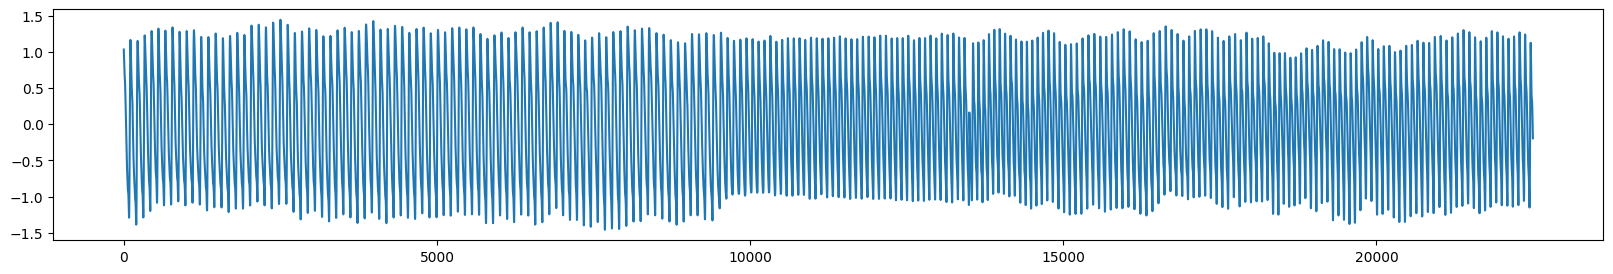

In [2258]:
plt.figure(figsize=(20,3))
# plt.plot(predictions)

plt.plot(np.concatenate([data_before_gap, predictions, data_after_gap]))

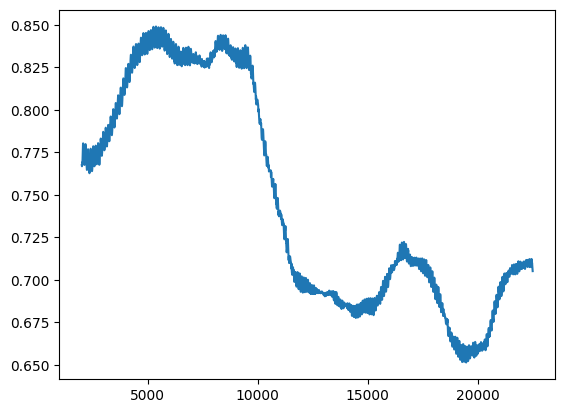

In [2263]:
plt.plot(pd.DataFrame(np.concatenate([data_before_gap, predictions, data_after_gap])).rolling(window=2000).std())

In [ ]:
x = np.concatenate([data_before_gap, predictions, data_after_gap])

data_gap = np.concatenate([data_before_gap[-n_lags:], x[gap_start:gap_end+1]])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


for i in range(2):
    test_gap_data = create_lags(data_gap, n_lags)

    prediction_before = rf_pre_gap.predict(test_gap_data.drop('lag_0', axis=1))
    prediction_after = rf_post_gap.predict(test_gap_data.drop('lag_0', axis=1))

    weights = np.linspace(0, 1, len(prediction_before))
    # weights = sigmoid(np.linspace(-6, 6, len(prediction_before)))
    # weight = 1 - i/gap_size
    # prediction = weight*prediction_before + (1-weight)*prediction_after
    prediction = prediction_before * (1 - weights) + prediction_after * weights

    data_gap = np.concatenate([data_before_gap[-n_lags:], prediction])

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(np.concatenate([data_before_gap, prediction, data_after_gap]))

C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\scipy\signal\_spectral_py.py:1492: UserWarning: NOLA condition failed, STFT may not be invertible
  warnings.warn("NOLA condition failed, STFT may not be invertible")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


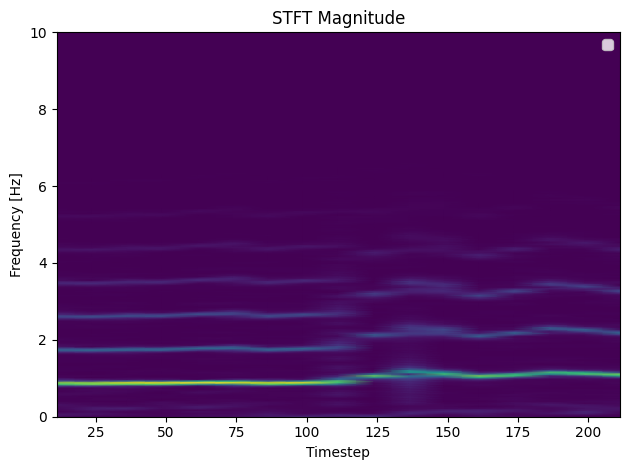

In [2205]:
frequencies, times, complex_data = stft(np.concatenate([data_before_gap, predictions, data_after_gap]), fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None, padded=False)
_, reconstructed_signal = istft(complex_data, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

fig, ax = plt.subplots()
plt.pcolormesh(times, frequencies, np.abs(complex_data), shading='gouraud')
ax.set_ylim([0, 10])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

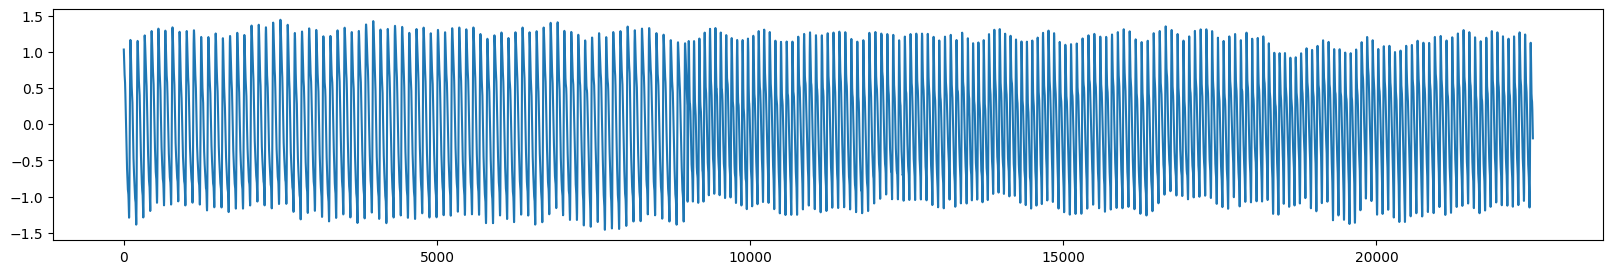

In [1973]:
plt.figure(figsize=(20,3))
# plt.plot(d)
d = np.concatenate([data_before_gap, filled_gap, data_after_gap])
plt.plot(d)

In [2077]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Conv2D, Reshape, Flatten

X = []
Y = []
window_size = segments*4

for i in range(window_size, Zxx.shape[1] - window_size - segments):
    # Data before and after the gap
    before_gap = Zxx[:, i-window_size:i]
    gap_values = Zxx[:, i:i+segments]
    after_gap = Zxx[:, i+segments:i+window_size+segments]
    # Data in the gap (what we want to predict)

    # Append the concatenated 'before_gap' and 'after_gap' to X
    # and 'gap_values' to Y
    X.append(np.concatenate((before_gap, after_gap), axis=1))
    Y.append(gap_values)

X = np.array(X)
Y = np.array(Y)
# X = np.expand_dims(np.array(X), axis=-1)
# Y = np.expand_dims(np.array(Y), axis=-1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [2078]:
X.shape, Y.shape

((34, 501, 8), (34, 501, 1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


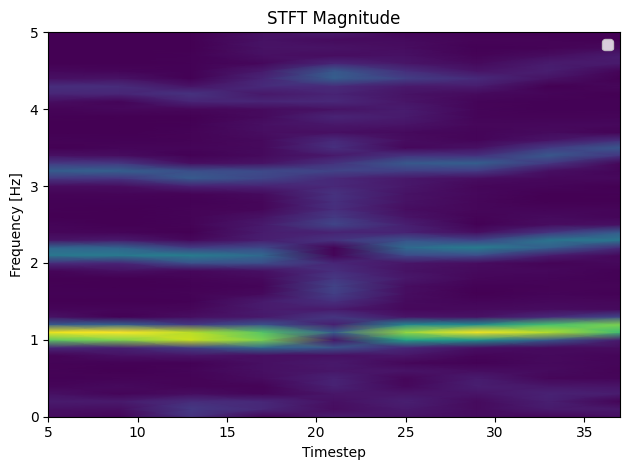

In [2119]:
_, x_gap_filled = istft(Zxx_combined, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)
f, t, Zxx_post = stft(x_gap_filled, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

filtered = np.abs(Zxx_post)

fig, ax = plt.subplots()
plt.pcolormesh(t, f, filtered, shading='gouraud')
ax.set_ylim([0, 5])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [2082]:
num_features = 2
X_train_real = np.abs(X_train)
X_train_imag = np.angle(X_train)
X_train = np.stack([X_train_real, X_train_imag], axis=-1)

Y_train_real = np.abs(Y_train)
Y_train_imag = np.angle(Y_train)
Y_train = np.stack([Y_train_real, Y_train_imag], axis=-1)

# Same for test data
X_test_real = np.abs(X_test)
X_test_imag = np.angle(X_test)
X_test = np.stack([X_test_real, X_test_imag], axis=-1)

Y_test_real = np.abs(Y_test)
Y_test_imag = np.angle(Y_test)
Y_test = np.stack([Y_test_real, Y_test_imag], axis=-1)

In [2083]:
X_train.shape, Y_train.shape, X_test.shape

((27, 501, 8, 2), (27, 501, 1, 2), (7, 501, 8, 2))

In [2084]:
X_train[0:1].shape, Y_train[1:2].shape

((1, 501, 8, 2), (1, 501, 1, 2))

In [2085]:
X_sample = X_train[1]
Y_sample = Y_train[1]

test = np.squeeze(X_sample)
ytest = np.squeeze(Y_sample)

test.shape, ytest.shape

((501, 8, 2), (501, 2))

In [2086]:
Zxx_truth = ytest[:, 0] * np.exp(1j * ytest[:, 1])

ZXX_before =  test[:,:window_size][..., 0] * np.exp(1j * test[:,:window_size][..., 1])
ZXX_after =  test[:,window_size:][..., 0] * np.exp(1j * test[:,window_size:][..., 1])

Zxx_combined = np.hstack([ZXX_before, np.expand_dims(Zxx_truth, axis=1), ZXX_after])

t, x_rec = istft(Zxx_combined, fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

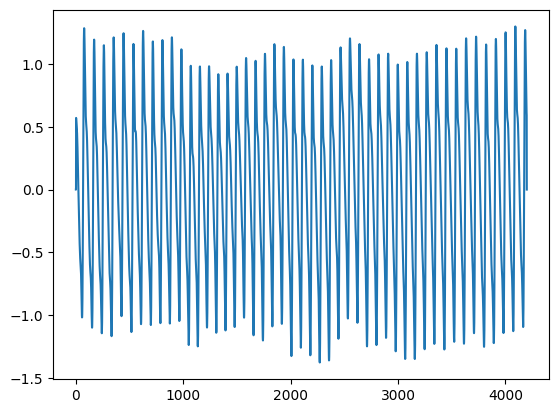

In [2087]:
plt.plot(x_rec)

In [6]:

_, x_gap_filled = istft(Zxx_combined, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)
f, t, Zxx_post = stft(x_gap_filled, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

filtered = np.abs(Zxx_post)

fig, ax = plt.subplots()
plt.pcolormesh(t, f, filtered, shading='gouraud')
ax.set_ylim([0, 5])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

NameError: name 'istft' is not defined

In [2097]:
import tensorflow as tf
from tensorflow.keras import layers


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class STFTGapFiller(tf.keras.Model):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, num_features=2):
        super(STFTGapFiller, self).__init__()
        self.dense = layers.Dense(embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim)
                                   for _ in range(num_layers)]
        self.classifier = layers.Dense(num_features)

    def call(self, inputs):
        x = tf.reshape(inputs, (-1, inputs.shape[2], inputs.shape[3]))
        x = self.dense(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = x[:, -1, :]  # Take the last time step
        outputs = self.classifier(x)

        outputs = tf.reshape(outputs, (-1, inputs.shape[1], 1, inputs.shape[3]))

        return outputs


num_layers = 6
embed_dim = 32
num_heads = 1
ff_dim = 32

model = STFTGapFiller(num_layers, embed_dim, num_heads, ff_dim)
model.compile("adam", "mse")

# Model training
model.fit(X_train, Y_train, batch_size=32, epochs=20)

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 2.7596
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 1.9362
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 2.0377
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 1.9968
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 1.8390
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 1.7215
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 1.6934
Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 1.6767
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 1.6780
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 1.6713
Epoch 11/20
1/1 [==============================] - 2s 2s/step - loss: 1.6426
Epoch 12/20
1/1 [==============================] - 2s 2s/step - loss: 1.6128
Epoch 13/20
1/1 [==============================] - 2s 2s/step - loss: 1.5838
Epoch 

In [1961]:
model.summary()

Model: "stft_gap_filler_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1261 (Dense)          multiple                  96        
                                                                 
 transformer_block_581 (Tran  multiple                 6464      
 sformerBlock)                                                   
                                                                 
 transformer_block_582 (Tran  multiple                 6464      
 sformerBlock)                                                   
                                                                 
 transformer_block_583 (Tran  multiple                 6464      
 sformerBlock)                                                   
                                                                 
 transformer_block_584 (Tran  multiple                 6464      
 sformerBlock)                                  

In [2116]:
pred = model.predict(X_test[0:1])
pred.shape

1/1 [==============================] - 0s 57ms/step


(1, 501, 1, 2)

In [2111]:
predicted_gap = model.predict(np.expand_dims(X_test[3], axis=0))
predicted_gap = np.squeeze(predicted_gap)

test = X_test[3]
ytest = Y_test[3]

Zxx_truth = ytest[..., 0] * np.exp(1j * ytest[..., 1])

ZXX_before =  test[:,:window_size][..., 0] * np.exp(1j * test[:,:window_size][..., 1])
ZXX_after =  test[:,window_size:][..., 0] * np.exp(1j * test[:,window_size:][..., 1])



magnitudes = predicted_gap[..., 0]
phases = predicted_gap[..., 1]

Zxx_pred = magnitudes * np.exp(1j * phases)

Zxx_combined = np.hstack([ZXX_before, np.expand_dims(Zxx_pred,axis=1), ZXX_after])
# Zxx_combined = np.hstack([ZXX_before, Zxx_truth, ZXX_after])

t, x_rec = istft(Zxx_combined, fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)


1/1 [==============================] - 0s 53ms/step


In [2074]:
predicted_gap = model.predict(np.expand_dims(X_train[0], axis=0))

test = X_train[0]
ytest = Y_train[0]

Zxx_truth = ytest[..., 0] * np.exp(1j * ytest[..., 1])

ZXX_before =  test[:,:window_size][..., 0] * np.exp(1j * test[:,:window_size][..., 1])
ZXX_after =  test[:,window_size:][..., 0] * np.exp(1j * test[:,window_size:][..., 1])

predicted_gap = np.squeeze(predicted_gap)

magnitudes = predicted_gap[..., 0]
phases = predicted_gap[..., 1]

Zxx_pred = magnitudes * np.exp(1j * phases)

Zxx_combined = np.hstack([ZXX_before, np.expand_dims(Zxx_pred,axis=1), ZXX_after])
# Zxx_combined = np.hstack([ZXX_before, Zxx_truth, ZXX_after])

t, x_rec = istft(Zxx_combined, fs=100,  time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)


1/1 [==============================] - 0s 48ms/step


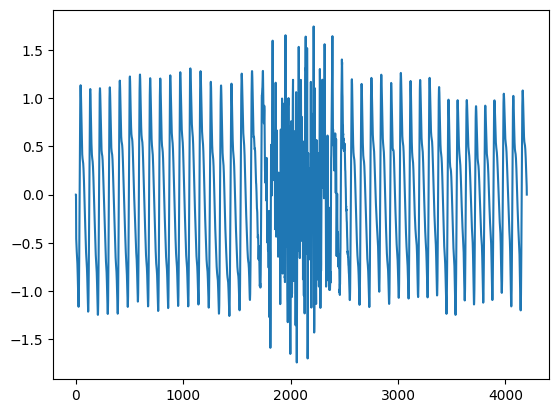

In [2112]:
plt.plot(x_rec)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


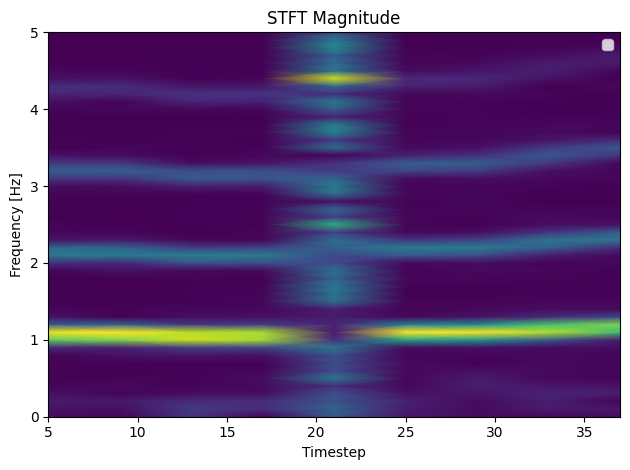

In [2113]:
_, x_gap_filled = istft(Zxx_combined, fs=100, time_axis=-1, freq_axis=-2, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)
#
#
f, t, Zxx_post = stft(x_gap_filled, fs=100, nperseg=SEGMENT_SIZE, noverlap=OVERLAP_SIZE, boundary=None)

filtered = np.abs(Zxx_combined)

fig, ax = plt.subplots()
plt.pcolormesh(t, f, filtered, shading='gouraud')
ax.set_ylim([0, 5])
# plt.axvline(x=gap_start, label='gap_start', color='purple')
# plt.axvline(x=gap_end, label='gap_end')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Timestep')
plt.tight_layout()
plt.legend()
plt.show()

In [978]:
from keras.layers import Conv1D

num_freq_bins = X_train.shape[1]
num_timesteps = X_train.shape[2]

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
# model.add(Flatten())
model.add(TimeDistributed(Flatten()))
# model.add(Reshape((-1, 64)))
# model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(segments))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 84, 6, 32)         608       
                                                                 
 time_distributed_21 (TimeDi  (None, 84, 192)          0         
 stributed)                                                      
                                                                 
 dense_19 (Dense)            (None, 84, 3)             579       
                                                                 
Total params: 1,187
Trainable params: 1,187
Non-trainable params: 0
_________________________________________________________________


In [925]:
# X_train = X_train.reshape(X_train.shape[0], num_freq_bins, -1)
# X_test = X_test.reshape(X_test.shape[0], num_freq_bins, -1)

model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\oliver.holly.HQ\Projects\seerlinq\venv\lib\site-packages\keras\losses.py", line 1470, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 300 and 2 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_28/dense_14/BiasAdd, mean_squared_error/Cast)' with input shapes: [?,300], [?,101,2].


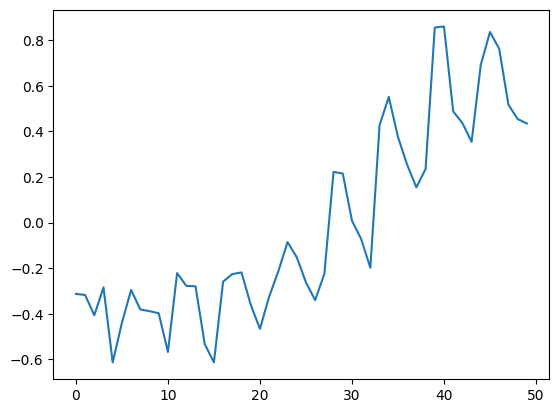

In [1023]:
plt.plot(x_rec[50:100])

In [871]:


# Let's assume input shape is (100, 100, 1) for the spectrogram image
input_shape = X_train.shape

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu',padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 135, 101, 4, 32)  320       
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 135, 12928)       0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 50)                2595800   
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2,596,222
Trainable params: 2,596,222
Non-trainable params: 0
_________________________________________________________________
